In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
from danmodels_v3 import unet
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from tensorflow.keras.models import load_model
from skimage.filters import threshold_otsu
from skimage.morphology import opening
from scipy.ndimage import label
from tqdm import tqdm

# This code assumes channel 0 is cardiomyocyte, and channel 1 is tissue, and channel 2 is nuclei. I'm keeping this particular order since the colors match with what is expect. Note* in a typical workflow, cardiomyocyte is absent, so the data should just be zeros.

In [2]:
def read_image_data(datadir,datafile):
    #this assumes that the file being loaded have 3 dimensions: first 2 dimensions of the data are the image itself
    #and the 3rd dimension is the rgb channel
    imbuff = imread(os.path.join(datadir,datafile['tissue'])).astype(np.float32)[...,1]
    im = np.zeros(shape=imbuff.shape+(3,),dtype=np.float32)
    im[...,1] = imbuff
    im[...,2] = imread(os.path.join(datadir,datafile['nuclei'])).astype(np.float32)[...,2]
    
    #normalize data from 0 to 1
    for ii in range(im.shape[-1]):
        if not (im[...,ii].max() == 0):
            im[...,ii] = im[...,ii]/im[...,ii].max()
    return im

def binary_object_extraction(labeled_image=None, num_objects=None):
    separated_image=np.zeros(((num_objects,)+labeled_image.shape),dtype=np.bool)
    for ii in tqdm(range(num_objects)):
        separated_image[ii][labeled_image==(ii+1)]=1
    return separated_image

def get_nuclei_masks(data,version='semantic'):
    nucthresh = threshold_otsu(data[...,2])
    mask = data[..., 2] > nucthresh
    opening(mask, out=mask)
    if version=='semantic':
        return mask
    elif version=='instance':
        rlabel, rnum =label(mask)
        sepmask=binary_object_extraction(labeled_image=rlabel,num_objects=rnum)
        return sepmask
    elif version=='count':
        rlabel, rnum =label(mask)
        #sepmask=binary_object_extraction(labeled_image=rlabel,num_objects=rnum)
        return rnum
    else:
        print('incorrect version specification')
        print('please use "semantic" or "instance" or "count"')
    

def get_cm_masks(data,k):
    mcdata = data[..., 0] - k * data[..., 1]
    mcdata[mcdata<0]=0
    myothresh = threshold_otsu(mcdata)
    mcmask = mcdata > myothresh
    opening(mcmask, out=mcmask)
    opening(mcmask, out=mcmask)
    mcmask = np.multiply(mcmask,get_nuclei_masks(data,'semantic'))
    return mcmask
    

def optimize_k(data, iter=100, evalcost=False):
    A = data[...,1]
    B = data[...,0]
    sigstep = np.divide(1, np.abs(A), out=np.zeros_like(A, dtype=float), where=A != 0)
    taustep = 1 / np.sum(np.abs(A))
    xp = 0
    xn = 0
    z = np.zeros_like(A, dtype=float)
    theta = 1
    cost = []
    klist = []

    for _ in tqdm(range(iter)):
        #         print(_)
        xp = xn - taustep * np.sum(np.multiply(A, z))
        xhat = xp + theta * (xp - xn)
        z = np.minimum(1, np.maximum(-1, z + np.multiply(sigstep, A * xhat) - np.multiply(sigstep, B)))

        xn = xp

        if evalcost:
            cost.append(np.sum(np.abs(A * xp - B)))
            klist.append(xp)
            
    if evalcost:
        plt.figure(figsize=(16,8))
        plt.plot(cost)
        plt.title('cost')
        plt.xlabel('iterations')
        plt.show()
        
        plt.figure(figsize=(16,8))
        plt.plot(klist)
        plt.title('k')
        plt.xlabel('iterations')
        plt.show()
        
    return xp

def patchwise_predict2D(x, model, numsize=(256, 256), stride=(128, 128)):
    X, Y= np.meshgrid(np.linspace(-1, 1, numsize[1]), np.linspace(-1, 1, numsize[0]))
    mu, sigma = 0, 2.5
    G = np.exp(-((X - mu) ** 2 + (Y - mu) ** 2) / 2.0 * sigma ** 2)

    ns_row = np.ceil((x.shape[0] - numsize[0]) / stride[0]).astype(int)
    ns_col = np.ceil((x.shape[1] - numsize[1]) / stride[1]).astype(int)

    padrow = ns_row * stride[0] + numsize[0] - x.shape[0]
    padcol = ns_col * stride[1] + numsize[1] - x.shape[1]

    npad = ((padrow, 0), (padcol, 0), (0, 0))

    x = np.pad(x, pad_width=npad, mode='constant', constant_values=0)
    ypred = np.zeros((x.shape[0], x.shape[1]))
    yweight = np.zeros((x.shape[0], x.shape[1]))

    progress = 0
    tot_progress = (ns_row + 1) * (ns_col + 1)
    for i in tqdm(range(ns_row + 1)):
        for j in range(ns_col + 1):
            row = i * stride[0]
            col = j * stride[1]
            xbuff = np.zeros((1, numsize[0], numsize[1], x.shape[-1]))
            xbuff[0, :, :, :] = x[row:row + numsize[0], col:col + numsize[1], :]
            ybuff = model.predict(xbuff)

            ypred[row:row + numsize[0], col:col + numsize[1]] = (
            np.divide(np.multiply(ypred[row:row + numsize[0], col:col + numsize[1]],
                                  yweight[row:row + numsize[0], col:col + numsize[1]])
                      + np.multiply(ybuff[0, :, :, 0], G),
                      G + yweight[row:row + numsize[0], col:col + numsize[1]]))
            yweight[row:row + numsize[0], col:col + numsize[1]] += G
            progress += 1
            # print(progress/tot_progress*100," percent complete         \r",)
    print("")
    ypred = np.delete(ypred, range(padrow), 0)
    ypred = np.delete(ypred, range(padcol), 1)
    return ypred

def predict_cm(data,model):
    x = np.flip(data,axis=2)[...,0:2]
    ypred = patchwise_predict2D(x, model, numsize=(256, 256), stride=(128, 128))
    return ypred

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def count_cm_and_nuclei(data,pmask,threshold,mode='slow'):    
    mask=get_nuclei_masks(data,version='semantic')
    #nucleicount is the count of nuclei
    rlabel, nucleicount =label(mask)
    
    if mode == 'slow':
        cmcount=0
        separated_nuclei=np.zeros(rlabel.shape,dtype=np.bool)

        for ii in tqdm(range(nucleicount)):
            separated_nuclei[...]=(rlabel==(ii+1))
            rmin, rmax, cmin, cmax = bbox(separated_nuclei)

            pval=np.sum(np.multiply(separated_nuclei[rmin:rmax+1,cmin:cmax+1],pmask[rmin:rmax+1,cmin:cmax+1]))/np.sum(separated_nuclei[rmin:rmax+1,cmin:cmax+1])

            if (pval>threshold):
                cmcount+=1
                
    elif mode == 'fast':
        cmlabel, cmcount = label(np.multiply(pmask,mask) > threshold)
        
    else:
        cmcount=None
        print('Error! mode argument should be either slow (accurate) or fast (inaccurate)')
        
    return cmcount, nucleicount

In [3]:
#threshold values for mode=='slow'
# alpha actinin tissue stain threshold= 0.108
# autoflourescense tissue stain threshold= 0.059
# titin tissue stain threshold= 0.099
# troponin male threshold= 0.071
# troponin female threshold= 0.05

#the curve is less sensitive on the right side of these numbers so im currently having 0.1 as my test value
threshold = 0.108

#other necessary data
datadir = 'raw/test/alpha actinin tissue stain'
datafile = {}
datafile['nuclei'] = '5-S1-right-Cre-a-actinin-20x-overlay-stitch_RGB_DAPI.tif'
datafile['tissue'] = '5-S1-right-Cre-a-actinin-20x-overlay-stitch_RGB_FITC.tif'

model = unet(data_shape=(256,256),
         channels_in=2,
         channels_out=1,
         starting_filter_number=32,
         kernel_size=(3,3),
         num_conv_per_pool=2,
         num_repeat_bottom_conv=0,
         pool_number=4,
         pool_size=(2,2),
         expansion_rate=2,
         dropout_type='block',
         dropout_rate=0.1,
         dropout_power=1/4,
         dropblock_size=3,
         add_conv_layers=0,
         add_conv_filter_number=32,
         add_conv_dropout_rate=None,
         final_activation='sigmoid',
         gn_type='groups',
         gn_param=32,
         weight_constraint=None)

model.load_weights('results/best_weights_1.hdf5')


print('Accessing',datafile)
data = read_image_data(datadir=datadir,datafile=datafile)

print('Optimizing k')
xcen = int(data.shape[0] / 2)
ycen = int(data.shape[1] / 2)
print('Image center is ',xcen,ycen)
s = 1024
k = optimize_k(data[xcen-s:xcen+s,ycen-s:ycen+s,:])

print('k = ',k)

print('Predicting cardiomyocytes')
pmask = predict_cm(data, model)

print('Analyzing Data')
cmcount, nucleicount = count_cm_and_nuclei(data,pmask,threshold,mode='slow')

print(cmcount, nucleicount)

using 2D operations
using dropblock with blocksize: 3
excluding weight constraints

Input: (None, 256, 256, 2)

(None, 256, 256, 32)           	groups: 32 	kernel: (3, 3) 	droprate: 0.05
(None, 128, 128, 64)           	groups: 32 	kernel: (3, 3) 	droprate: 0.05946035575013606
(None, 64, 64, 128)            	groups: 32 	kernel: (3, 3) 	droprate: 0.07071067811865477
(None, 32, 32, 256)            	groups: 32 	kernel: (3, 3) 	droprate: 0.08408964152537146
(None, 16, 16, 512)            	groups: 32 	kernel: (3, 3) 	droprate: 0.1
(None, 32, 32, 256)            	groups: 32 	kernel: (3, 3) 	droprate: 0.08408964152537146
(None, 64, 64, 128)            	groups: 32 	kernel: (3, 3) 	droprate: 0.07071067811865477
(None, 128, 128, 64)           	groups: 32 	kernel: (3, 3) 	droprate: 0.05946035575013606
(None, 256, 256, 32)           	groups: 32 	kernel: (3, 3) 	droprate: 0.05

Output: (None, 256, 256, 1)

Successfully built 2D U-net model
Accessing {'nuclei': '5-S1-right-Cre-a-actinin-20x-overlay-s

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Optimizing k
Image center is  7019 4991


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


k =  0.0
Predicting cardiomyocytes


100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [09:14<00:00,  5.08s/it]



Analyzing Data


100%|██████████████████████████████████████████████████████████████████████████| 33614/33614 [1:43:32<00:00,  5.41it/s]

11296 33614


In [8]:
#There is also a fast mode but it won't match the paper
print('Analyzing Data')
cmcount, nucleicount = count_cm_and_nuclei(data,pmask,0.25,mode='fast')
print(cmcount, nucleicount)

Analyzing Data
11429 33614


(14038, 9982) (14038, 9982)
False
1.602843155272241e-07


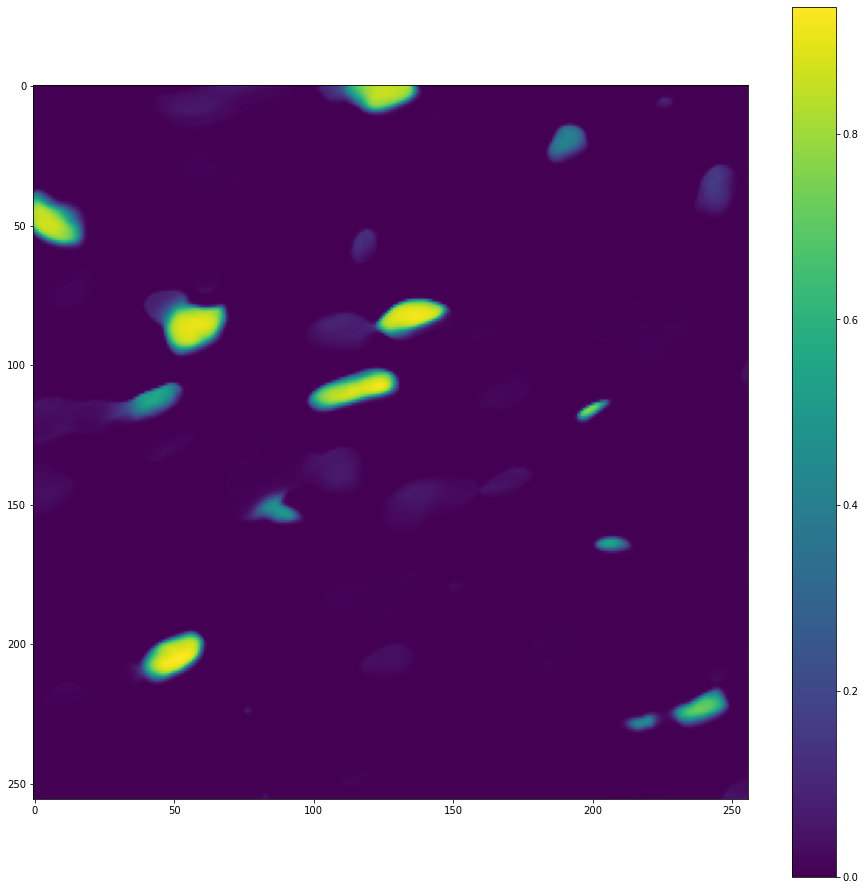

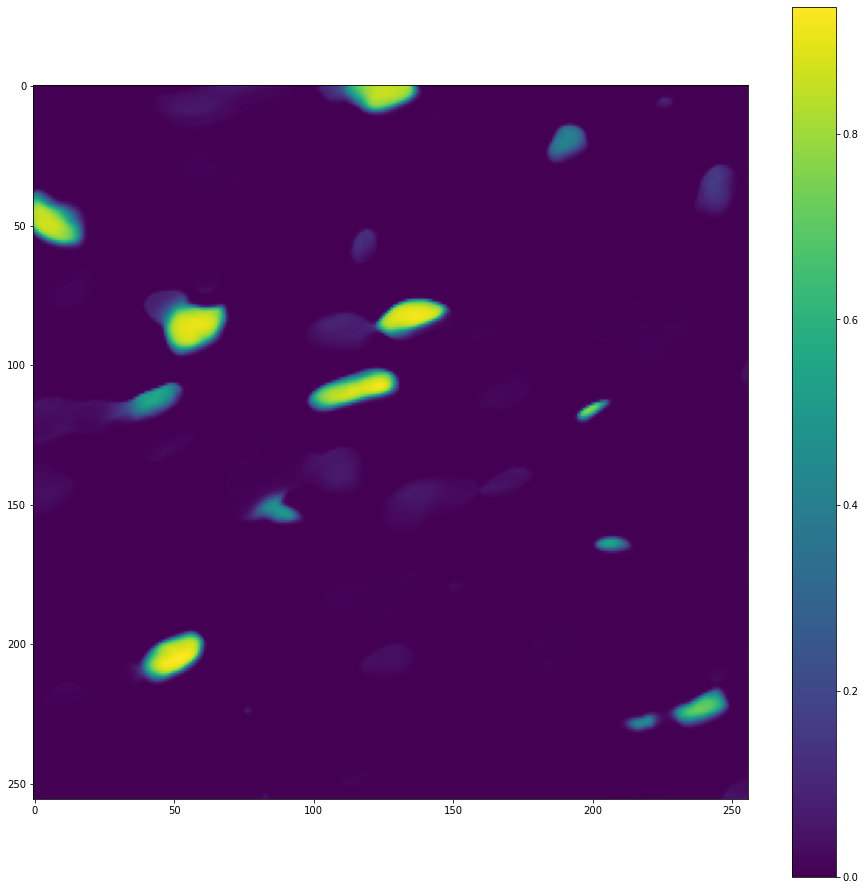

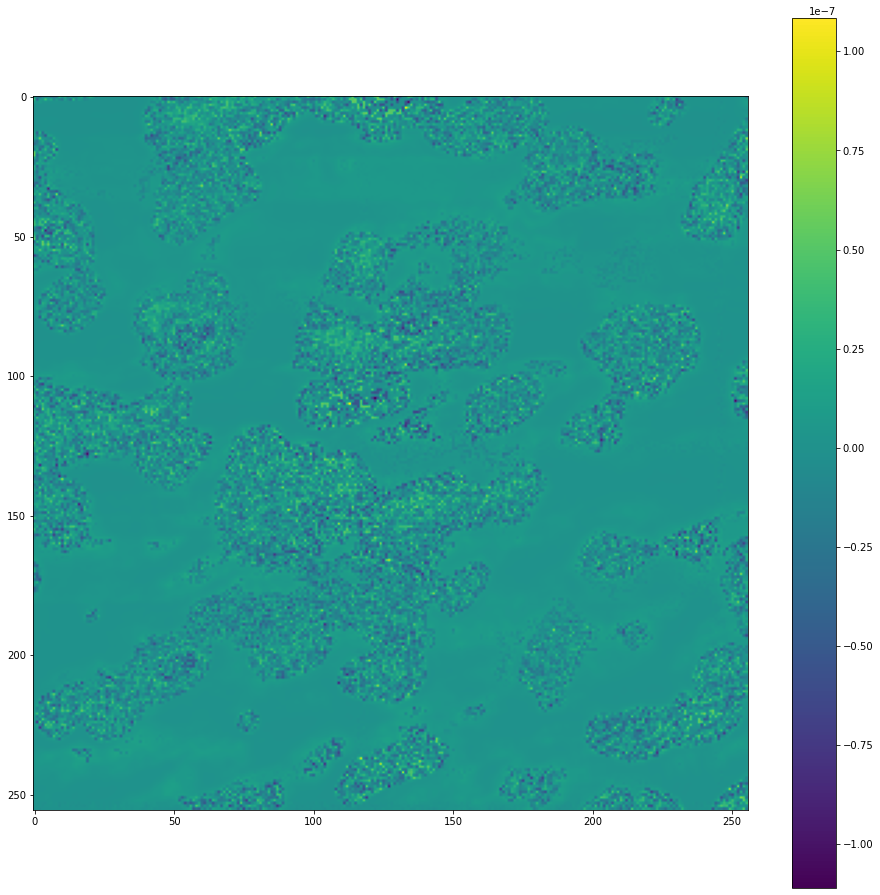

In [5]:
#Brandon ignore the code down here. Some consistency check to make sure my predicted CMs here match what I got for the paper
pmaskpaper=np.load('results/analysis/alpha actinin tissue stain/pmask_file05s1r_fold1.npy')
print(pmask.shape,pmaskpaper.shape)
print(np.array_equal(pmask,pmaskpaper))
print(np.max(np.abs(pmask-pmaskpaper)))
plt.figure(figsize=(16,16))
plt.imshow(pmask[7000:7256,5000:5256])
plt.colorbar()
plt.show()
plt.figure(figsize=(16,16))
plt.imshow(pmaskpaper[7000:7256,5000:5256])
plt.colorbar()
plt.show()
plt.figure(figsize=(16,16))
plt.imshow((pmask-pmaskpaper)[7000:7256,5000:5256])
plt.colorbar()
plt.show()